In [4]:
import pandas as pd
# Set max columns displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load data
test_id = pd.read_csv('train_identity.csv')
test_trans = pd.read_csv('train_transaction.csv')

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
test_id = reduce_mem_usage(test_id)
test_trans = reduce_mem_usage(test_trans)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


Analyze train_identity

In [8]:
# Dimensions of data
test_id.shape

(144233, 41)

In [9]:
# Data types
test_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int32
id_01            144233 non-null float16
id_02            140872 non-null float32
id_03            66324 non-null float16
id_04            66324 non-null float16
id_05            136865 non-null float16
id_06            136865 non-null float16
id_07            5155 non-null float16
id_08            5155 non-null float16
id_09            74926 non-null float16
id_10            74926 non-null float16
id_11            140978 non-null float16
id_12            144233 non-null object
id_13            127320 non-null float16
id_14            80044 non-null float16
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float16
id_18            45113 non-null float16
id_19            139318 non-null float16
id_20            139261 non-null float16
id_21            5159 non-null float16
id_2

In [10]:
# Summary of columns
test_id.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.0,140872.0000,66324.000000,66324.000000,136865.0,136865.0,5155.000000,5155.000000,74926.000000,74926.00000,140978.0,127320.0,80044.0,139369.0,4.511300e+04,139318.0,139261.0,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.0
mean,3.236329e+06,NaN,174716.9375,0.060150,-0.058929,NaN,NaN,inf,-inf,0.091003,-0.30127,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,inf,12.796875,inf,inf,NaN
std,1.788496e+05,0.0,159650.0000,0.598145,0.701172,0.0,0.0,11.382812,26.078125,0.000000,0.00000,0.0,0.0,NaN,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.375000,97.437500,32.093750,0.0
min,2.987004e+06,-100.0,1.0000,-13.000000,-28.000000,-72.0,-100.0,-46.000000,-100.000000,-36.000000,-100.00000,90.0,10.0,-660.0,100.0,1.000000e+01,100.0,100.0,100.000000,10.000000,11.000000,100.000000,100.000000,0.0
25%,3.077142e+06,-10.0,67992.0000,0.000000,0.000000,0.0,-6.0,5.000000,-48.000000,0.000000,0.00000,100.0,49.0,-360.0,166.0,1.300000e+01,266.0,256.0,252.000000,14.000000,11.000000,321.000000,119.000000,24.0
50%,3.198818e+06,-5.0,125800.5000,0.000000,0.000000,0.0,0.0,14.000000,-34.000000,0.000000,0.00000,100.0,52.0,-300.0,166.0,1.500000e+01,341.0,472.0,252.000000,14.000000,11.000000,321.000000,149.000000,24.0
75%,3.392923e+06,-5.0,228749.0000,0.000000,0.000000,1.0,0.0,22.000000,-23.000000,0.000000,0.00000,100.0,52.0,-300.0,225.0,1.500000e+01,427.0,533.0,486.500000,14.000000,15.000000,371.000000,169.000000,32.0
max,3.577534e+06,0.0,999595.0000,10.000000,0.000000,52.0,0.0,61.000000,0.000000,25.000000,0.00000,100.0,64.0,720.0,229.0,2.900000e+01,671.0,661.0,854.000000,44.000000,26.000000,548.000000,216.000000,32.0


In [11]:
# Preview data
test_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Analyze train_transaction

In [12]:
test_trans.shape

(590540, 394)

In [13]:
test_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float16(332), float32(44), int16(1), int32(2), int8(1), object(14)
memory usage: 542.3+ MB


In [14]:
test_trans.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,3.762700e+04,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,3.891700e+04,74926.000000,74926.000000,514518.0,311253.0,6.471700e+04,6.195200e+04,6.218700e+04,501427.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,81945.000000,81945.0,81945.0,81945.000000,81945.000000,81951.0,81951.0,81951.0,81945.000000,81945.000000,81945.000000,81945.000000,81951.0,81951.0,81951.0,81945.000000,81945.000000,81945.000000,81945.000000,81945.0,81945.0,81951.0,81951.000000,81945.0,81945.0,81945.0,81951.000000,81951.000000,81951.000000,139631.0,139631.0,139819.000000,139819.0,139819.0,139631.000000,139631.000000,139819.000000,139819.000000,139631.0,139631.0,139631.0,139631.0,139819.0,139631.00

In [15]:
test_trans.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.

In [16]:
test_trans.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,T,T,T,M0,T,F,F,F,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0,47.9375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0,47.9375,0.0,0.0,47.9375,47.9375,47.9375,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,F,F,M0,F,T,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.

In [17]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [18]:
resumetable(test_trans)

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,nan,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


In [19]:
resumetable(test_id)

Dataset Shape: (144233, 41)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,144233,2987004,2987008,2987010,17.14
1,id_01,float16,0,77,0,-5,-5,2.27
2,id_02,float32,3361,115655,70787,98945,191631,16.72
3,id_03,float16,77909,24,nan,nan,0,0.32
4,id_04,float16,77909,15,nan,nan,0,0.10
5,id_05,float16,7368,93,nan,0,0,2.40
6,id_06,float16,7368,101,nan,-5,0,2.63
7,id_07,float16,139078,84,nan,nan,nan,5.39
8,id_08,float16,139078,94,nan,nan,nan,5.72
9,id_09,float16,69307,46,nan,nan,0,0.51


# First goal: We are doing fraud detection, so let us visualize the fraudulent transactions first.

In [20]:
test_trans['TransactionAmt'] = test_trans['TransactionAmt'].astype(float)

In [21]:
total_trans = len(test_trans)

first step, compare the total transactions vs fraud transactions

In [22]:
# https://stackoverflow.com/questions/39922986/pandas-group-by-and-sum
total_transaction_amount = test_trans['TransactionAmt'].sum()
# https://stackoverflow.com/questions/1823058/how-to-print-number-with-commas-as-thousands-separators
f'{round(total_transaction_amount, 2):,}'

'79,739,049.74'

NOTE: It is odd that transactions have so many decimals, it is possible that they come from taxes or other forms of financial transactions.

In [23]:
fraud_transactions = test_trans[test_trans['isFraud'] == 1]['TransactionAmt'].sum()
f'{round(fraud_transactions, 2):,}'

'3,083,836.06'

In [24]:
non_fraud_transactions = test_trans[test_trans['isFraud'] == 0]['TransactionAmt'].sum()
f'{round(non_fraud_transactions, 2):,}'

'76,655,213.68'

In [25]:
fraud_transactions + non_fraud_transactions == total_transaction_amount

True

In [26]:
fraud_count = test_trans[test_trans['isFraud'] == 1]['TransactionAmt'].count()
non_fraud_count = test_trans[test_trans['isFraud'] == 0]['TransactionAmt'].count()

In [27]:
total_trans == fraud_count + non_fraud_count

True

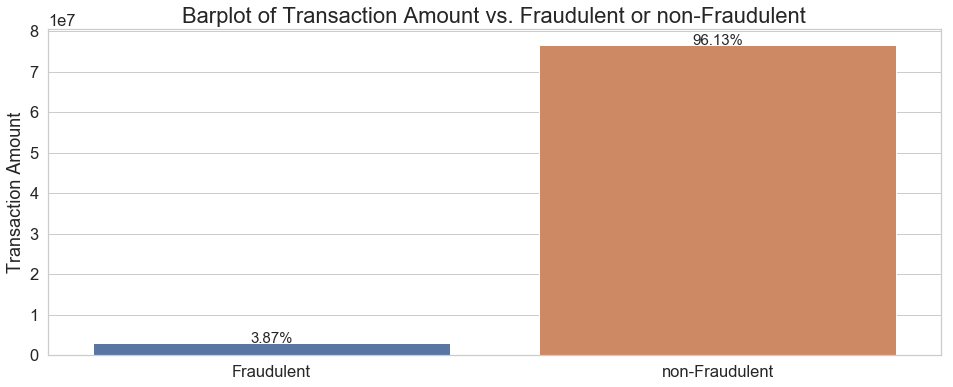

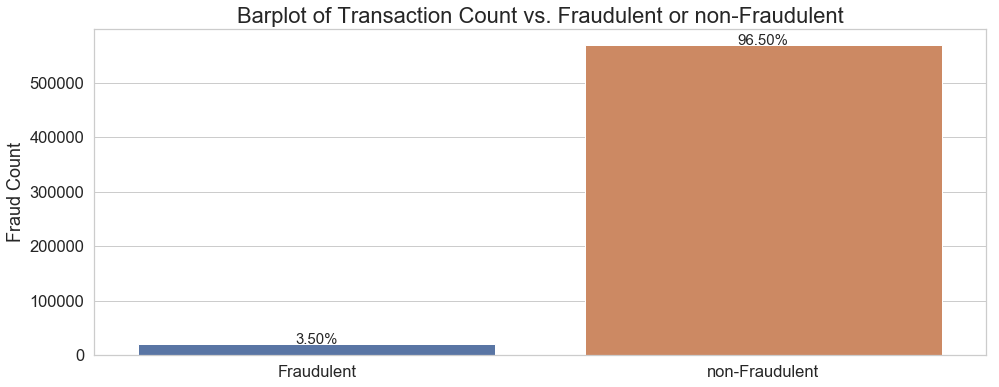

In [28]:
plt.figure(figsize=(16,6))
# https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
fraud_data = {'Fraudulent':['Fraudulent', 'non-Fraudulent'],
              'Transaction Amount':[fraud_transactions, non_fraud_transactions]}
fraud_data = pd.DataFrame(fraud_data)
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# https://stackoverflow.com/questions/42404154/increase-tick-label-font-size-in-seaborn
sns.set(style="whitegrid", font_scale=1.5)
ax = sns.barplot(x="Fraudulent", y="Transaction Amount", data=fraud_data)
ax.set_title('Barplot of Transaction Amount vs. Fraudulent or non-Fraudulent', fontsize=22)
ax.set_xlabel('') # Remove the 'Fraudulent' column name from the bottom
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_transaction_amount * 100),
            ha="center", fontsize=15)

plt.figure(figsize=(16,6))
fraud_count_data = {'Fraudulent':['Fraudulent', 'non-Fraudulent'],
              'Fraud Count':[fraud_count, non_fraud_count]}
fraud_count_data = pd.DataFrame(fraud_count_data)
sns.set(style="whitegrid", font_scale=1.5)
ax = sns.barplot(x="Fraudulent", y="Fraud Count", data=fraud_count_data)
ax.set_title('Barplot of Transaction Count vs. Fraudulent or non-Fraudulent', fontsize=22)
ax.set_xlabel('') # Remove the 'Fraudulent' column name from the bottom
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_trans*100),
            ha="center", fontsize=15) 

## Analyze the distributions of the transaction amounts for fraudulent vs. non-fraudulent charges

In [29]:
fraud_dist = test_trans[test_trans['isFraud'] == 1]['TransactionAmt']
non_fraud_dist = test_trans[test_trans['isFraud'] == 0]['TransactionAmt']

C:\Users\qizhe\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

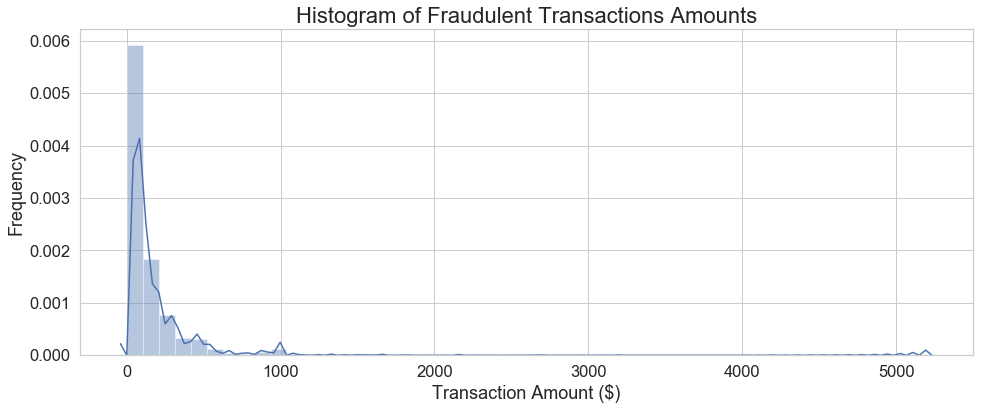

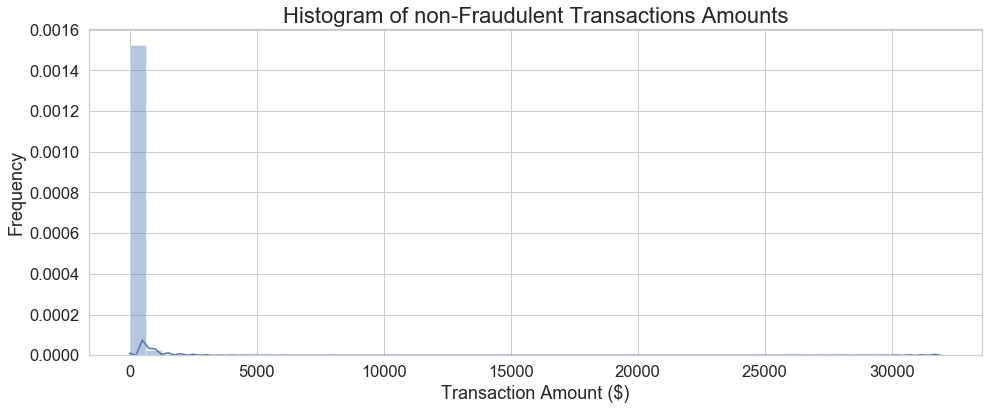

In [30]:
plt.figure(figsize=(16,6))
ax = sns.distplot(fraud_dist)
ax.set_title('Histogram of Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

plt.figure(figsize=(16,6))
ax = sns.distplot(non_fraud_dist)
ax.set_title('Histogram of non-Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

## Re-examine them both with certain outliers removed.

In [31]:
def subset_by_iqr(df, column, whisker_width=1.5):
#     https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     

In [32]:
fraud_dist_outlier = subset_by_iqr(pd.DataFrame(fraud_dist), 'TransactionAmt', whisker_width=1.5)
non_fraud_dist_outlier = subset_by_iqr(pd.DataFrame(non_fraud_dist), 'TransactionAmt', whisker_width=1.5)

Text(0, 0.5, 'Frequency')

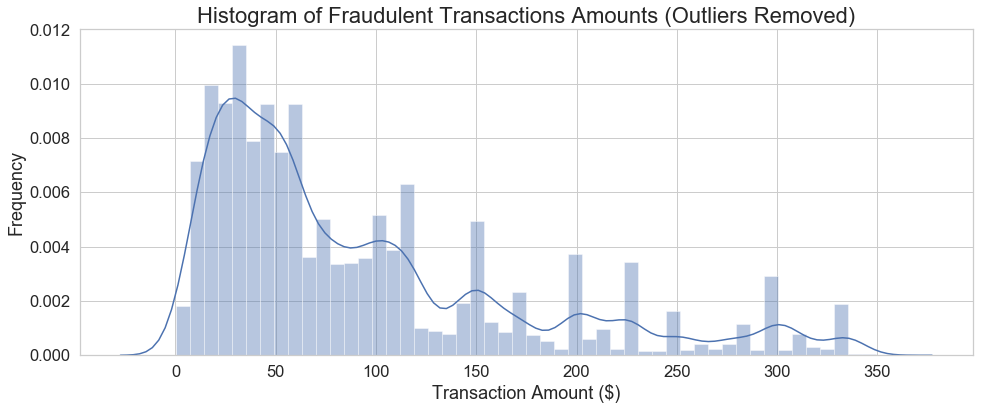

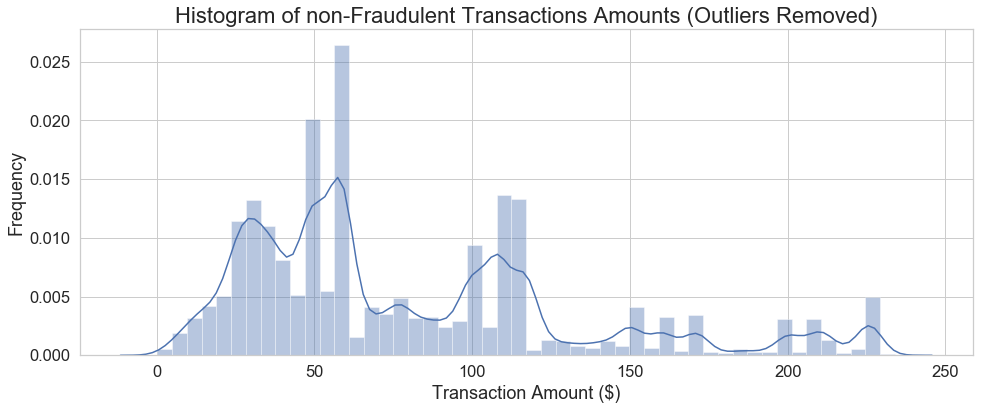

In [33]:
plt.figure(figsize=(16,6))
ax = sns.distplot(fraud_dist_outlier)
ax.set_title('Histogram of Fraudulent Transactions Amounts (Outliers Removed)', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

plt.figure(figsize=(16,6))
ax = sns.distplot(non_fraud_dist_outlier)
ax.set_title('Histogram of non-Fraudulent Transactions Amounts (Outliers Removed)', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

## Re-examine with log of original (outliers remain).

Text(0.5, 0, 'Transaction Amount ($)')

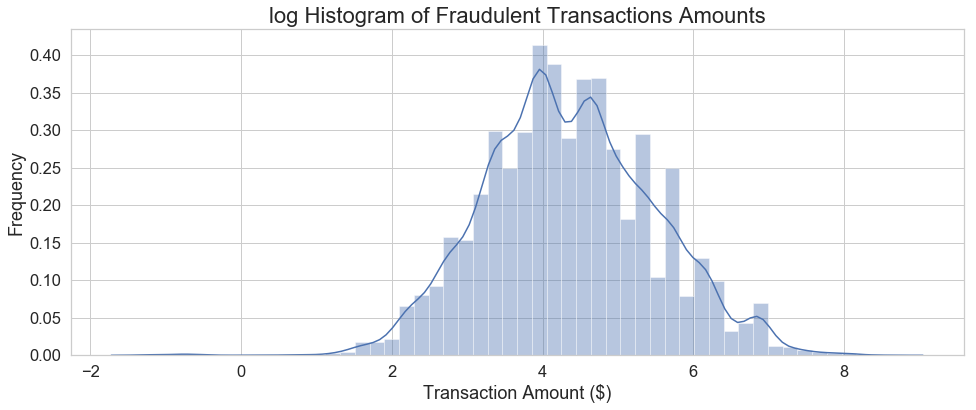

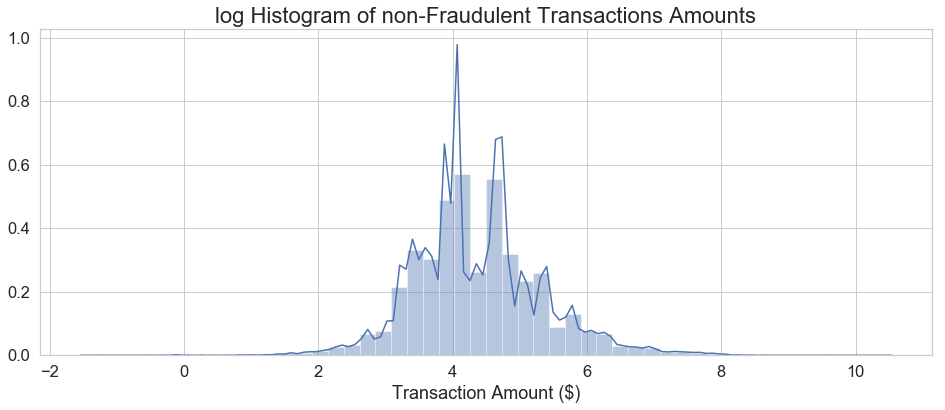

In [34]:
plt.figure(figsize=(16,6))
ax = sns.distplot(np.log(fraud_dist))
ax.set_title('log Histogram of Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

plt.figure(figsize=(16,6))
ax = sns.distplot(np.log(non_fraud_dist))
ax.set_title('log Histogram of non-Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')

## Re-examine them both with certain outliers removed (log version).

Text(0.5, 0, 'Transaction Amount ($)')

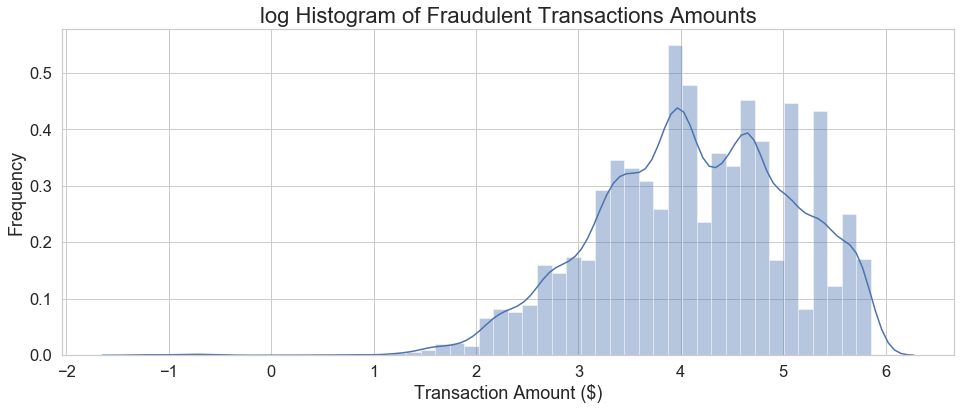

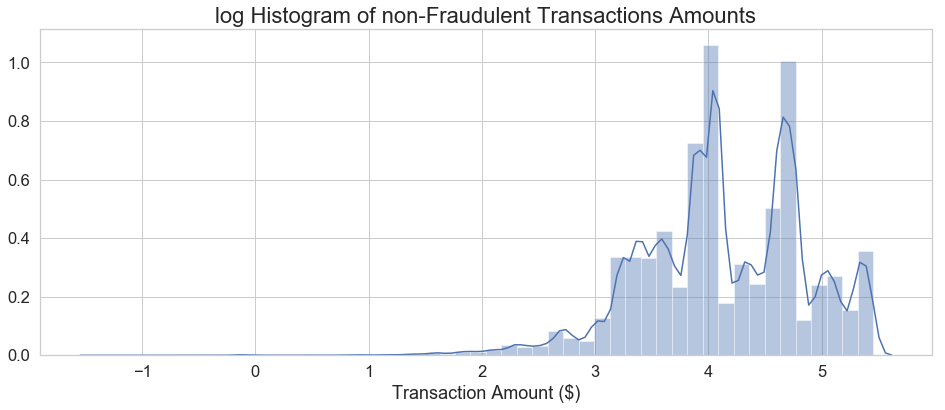

In [35]:
plt.figure(figsize=(16,6))
ax = sns.distplot(np.log(fraud_dist_outlier))
ax.set_title('log Histogram of Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')
ax.set_ylabel('Frequency')

plt.figure(figsize=(16,6))
ax = sns.distplot(np.log(non_fraud_dist_outlier))
ax.set_title('log Histogram of non-Fraudulent Transactions Amounts', fontsize=22)
ax.set_xlabel('Transaction Amount ($)')

### Results of histogram:
- Normal histogram (fraud)
    - heavily right skewed
- Normal histogram (non-fraud)
    - heavily right skewed
- log histogram (fraud)
    - distribution appears closer to normal
- log histogram (non-fraud)
    - distribution appears closer to normal
- Normal histogram (fraud) (w/o outliers)
    - less right skew, observations are bunched towards the lower end
- Normal histogram (non-fraud) (w/o outliers)
    - less right skew, observations have various peaks
- log histogram (fraud) (w/o outliers)
    - data appears left skewed, somewhat normal
- log histogram (non-fraud) (w/o outliers)
    - data appears left skewed, two sharp peaks

In [36]:
def CalcOutliers(df_num):
    whisker_width = 1.5
    q1 = df_num.quantile(0.25)                 
    q3 = df_num.quantile(0.75)
    iqr = q3 - q1

    #Calculating the higher and lower cut values
    lower, upper = q1 - whisker_width*iqr, q3 + whisker_width*iqr

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [37]:
CalcOutliers(test_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 66481
Total outlier observations: 66481
Non-outlier observations: 524059
Total percentual of Outliers:  12.6858


# Logistic regression

The problem in this project is a binary classification problem and for that reason the primary tool for prediction will be logistic regression. The category of fraudulent vs. non-fraudulent is a categorical variable, where neither fraudulent or non-fraudulent can be considered higher or lower than the other. For that reason, it is nominal rather than ordinal.

The data we have is count data, so it will be following a Poisson distribution. Possibly Poisson, not independent?
https://www.youtube.com/watch?v=sv_KXSiorFk

There seems to be issues with the Poisson assumptions. It is definitely count data, but it is difficult to determine whether these events are occuring in a specific time or space. If it were time we could say from start to end date. If it were space or area we could say North America.

Approximately Poisson process? Instead it is possible that the random variable approximately follows a Poisson process and we can try to model it as such.

Fraudulent  | Frequency | Proportion
------------- | ------------- | -------------
Yes  | 20,663 | 0.03499
No  | 569,877 | 0.96501
Total | 590,540 |

In [38]:
total_trans == fraud_count + non_fraud_count

True

Independence? $P(A \cap B) = P(A)P(B)$ How to test? Monte Carlo?

Mean and variance should be similar for Poisson regression. Different for sample means/sample variance.

Possible sci-kit learn solution, use weights in logistic regression. https://chrisalbon.com/machine_learning/logistic_regression/handling_imbalanced_classes_in_logistic_regression/

In [1]:
# assume your data is df, and it's a pd dataframe
# "class" is either fradulent (0) and non-fradudulent (1)

frad_df = df[df['class'] == 0].reset_index(drop=True)
non_frad_df = df[df['class'] == 1].reset_index(drop=True)

random_sample_idx = np.random.choice(range(frad_df.shape[0]), size=non_frad_df.shape[0], replace=True)
frad_sample_df = frad_df.iloc[random_sample_idx]
balanced_df = pd.concat([non_frad_df, frad_sample_df]).reset_index(drop=True)

NameError: name 'df' is not defined